In [1]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- CONFIGURACIÓN DE CONEXIÓN ---
# ¡ADVERTENCIA! Reemplaza estos valores con tus credenciales de PostgreSQL.
DB_HOST = "localhost"
DB_NAME = "project1"
DB_USER = "postgres"
DB_PASS = "12345"
DB_PORT = 5432
# ---------------------------------

conn = None # Inicializar conn

try:
    # 1. Conexión usando los parámetros directos (Método recomendado para psycopg2)
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS,
        port=DB_PORT
    )

    # 2. Abrir un cursor para ejecutar comandos
    cursor = conn.cursor()

    # 3. Testear la conexión
    cursor.execute("SELECT 1")
    # Si la ejecución es exitosa, la conexión funciona
    print("✅ Conexión a la base de datos exitosa!")

except psycopg2.Error as e:
    print(f"❌ Error al conectar a PostgreSQL: {e}")
    conn = None

# 4. Asegurarse de cerrar la conexión si se estableció
# if conn:
#     conn.close()
    # print("Conexión cerrada.")

✅ Conexión a la base de datos exitosa!


In [3]:
sql_hourly = f"""
    SELECT * FROM datos.hourly;
    """
sql_daily = f"""
    SELECT * FROM datos.daily;
    """
sql_uv = f"""
    SELECT * FROM datos.uv;
    """

dfh = pd.read_sql(sql_hourly, conn)
dfd = pd.read_sql(sql_daily, conn)
dfuv = pd.read_sql(sql_uv, conn)

C:\Users\je_z_\AppData\Local\Temp\ipykernel_16804\525049879.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfh = pd.read_sql(sql_hourly, conn)
C:\Users\je_z_\AppData\Local\Temp\ipykernel_16804\525049879.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfd = pd.read_sql(sql_daily, conn)
C:\Users\je_z_\AppData\Local\Temp\ipykernel_16804\525049879.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfuv = pd.read_sql(sql_uv, conn)


# Punto 1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [5]:
# --- Asumiendo que tu DataFrame de datos diarios se llama 'dfd' ---
# dfd = tu DataFrame cargado de la tabla daily

# 1. Eliminar las primeras 11 filas
print(f"Filas iniciales: {len(dfd)}")
dfd = dfd.iloc[11:].copy()
print(f"Filas después de la limpieza inicial: {len(dfd)}")

# 2. Asegurar que el índice sea de tipo datetime (fundamental para series de tiempo)
# Asumimos que la columna 'time' (o el índice) ya ha sido convertida a DATE en la carga.
if 'time' in dfd.columns:
    dfd['time'] = pd.to_datetime(dfd['time'])
    dfd = dfd.set_index('time')
    
# 3. Asegurar que la variable principal sea numérica
variable_estudio = 'precipitation_probability_mean'
dfd[variable_estudio] = pd.to_numeric(dfd[variable_estudio], errors='coerce')

# 4. Eliminar filas donde la variable de estudio principal sea NaN
dfd = dfd.dropna(subset=[variable_estudio])

Filas iniciales: 108
Filas después de la limpieza inicial: 97



--- Estadísticas Descriptivas ---
count    97.000000
mean     33.144330
std      16.663327
min       5.000000
25%      21.000000
50%      30.000000
75%      42.000000
max      75.000000
Name: precipitation_probability_mean, dtype: float64


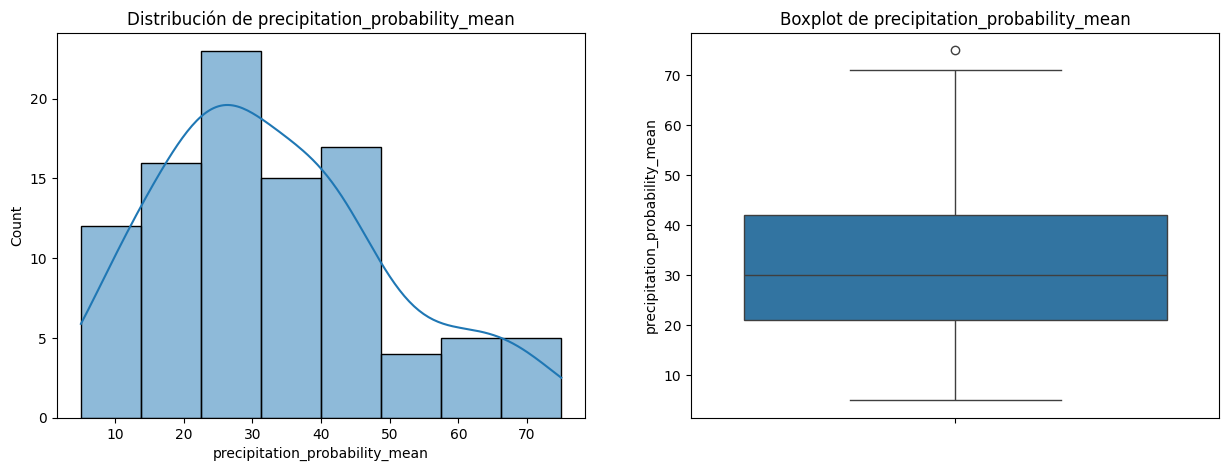

In [6]:
# Estadísticas descriptivas de la variable de estudio
print("\n--- Estadísticas Descriptivas ---")
print(dfd[variable_estudio].describe())

# Histograma y Boxplot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(dfd[variable_estudio], kde=True)
plt.title(f'Distribución de {variable_estudio}')

plt.subplot(1, 2, 2)
sns.boxplot(y=dfd[variable_estudio])
plt.title(f'Boxplot de {variable_estudio}')
plt.show()

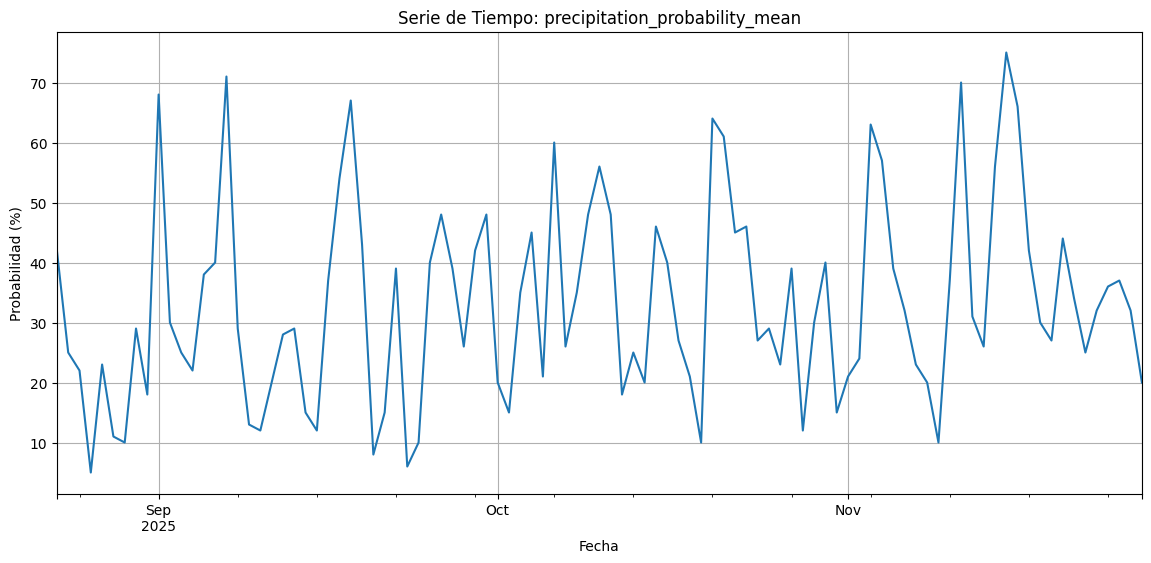

In [7]:
# Gráfico de series de tiempo para identificar tendencia y estacionalidad visualmente
plt.figure(figsize=(14, 6))
dfd[variable_estudio].plot(title=f'Serie de Tiempo: {variable_estudio}')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad (%)')
plt.grid(True)
plt.show()

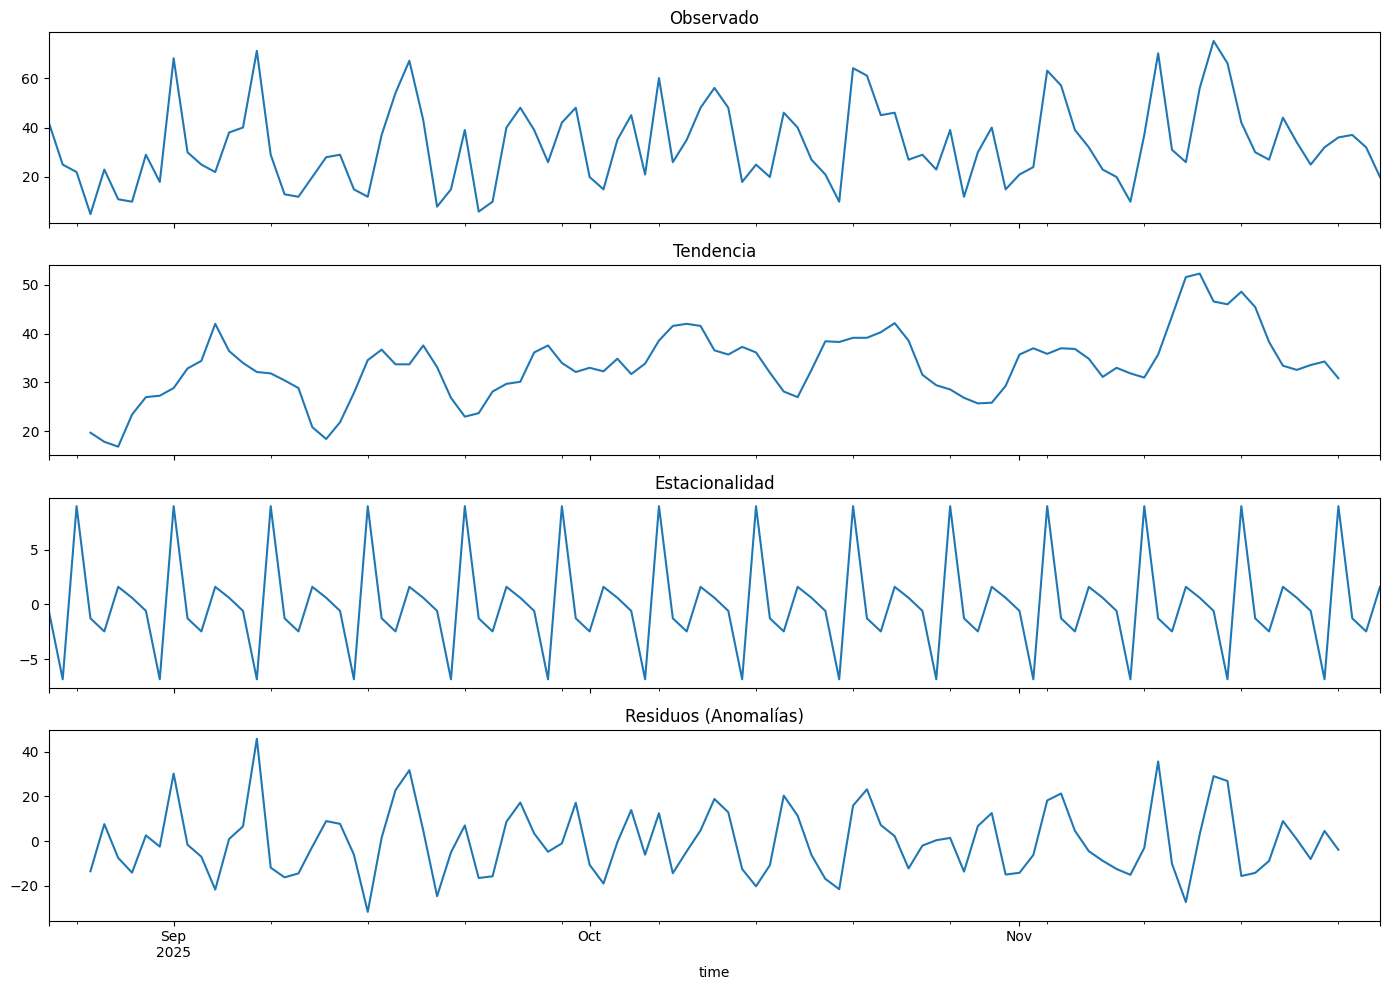

In [8]:
# La estacionalidad se puede ajustar (ej. 365.25 días para estacionalidad anual)
# Si tus datos son muy largos, puedes probar 'period=365' o 'period=365.25'
decomposition = seasonal_decompose(dfd[variable_estudio], model='additive', period=7) # Asumiendo estacionalidad anual

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decomposition.observed.plot(ax=ax1, title='Observado')
decomposition.trend.plot(ax=ax2, title='Tendencia')
decomposition.seasonal.plot(ax=ax3, title='Estacionalidad')
decomposition.resid.plot(ax=ax4, title='Residuos (Anomalías)')
plt.tight_layout()
plt.show()


--- Correlación de precipitation_probability_mean con otras variables ---
precipitation_probability_mean    1.000000
precipitation_probability_max     0.689162
precipitation_sum                 0.686160
showers_sum                       0.685738
precipitation_probability_min     0.658508
relative_humidity_2m_min          0.443996
relative_humidity_2m_mean         0.385860
cloud_cover_min                   0.383904
cloud_cover_mean                  0.362312
weather_code                      0.296905
Name: precipitation_probability_mean, dtype: float64


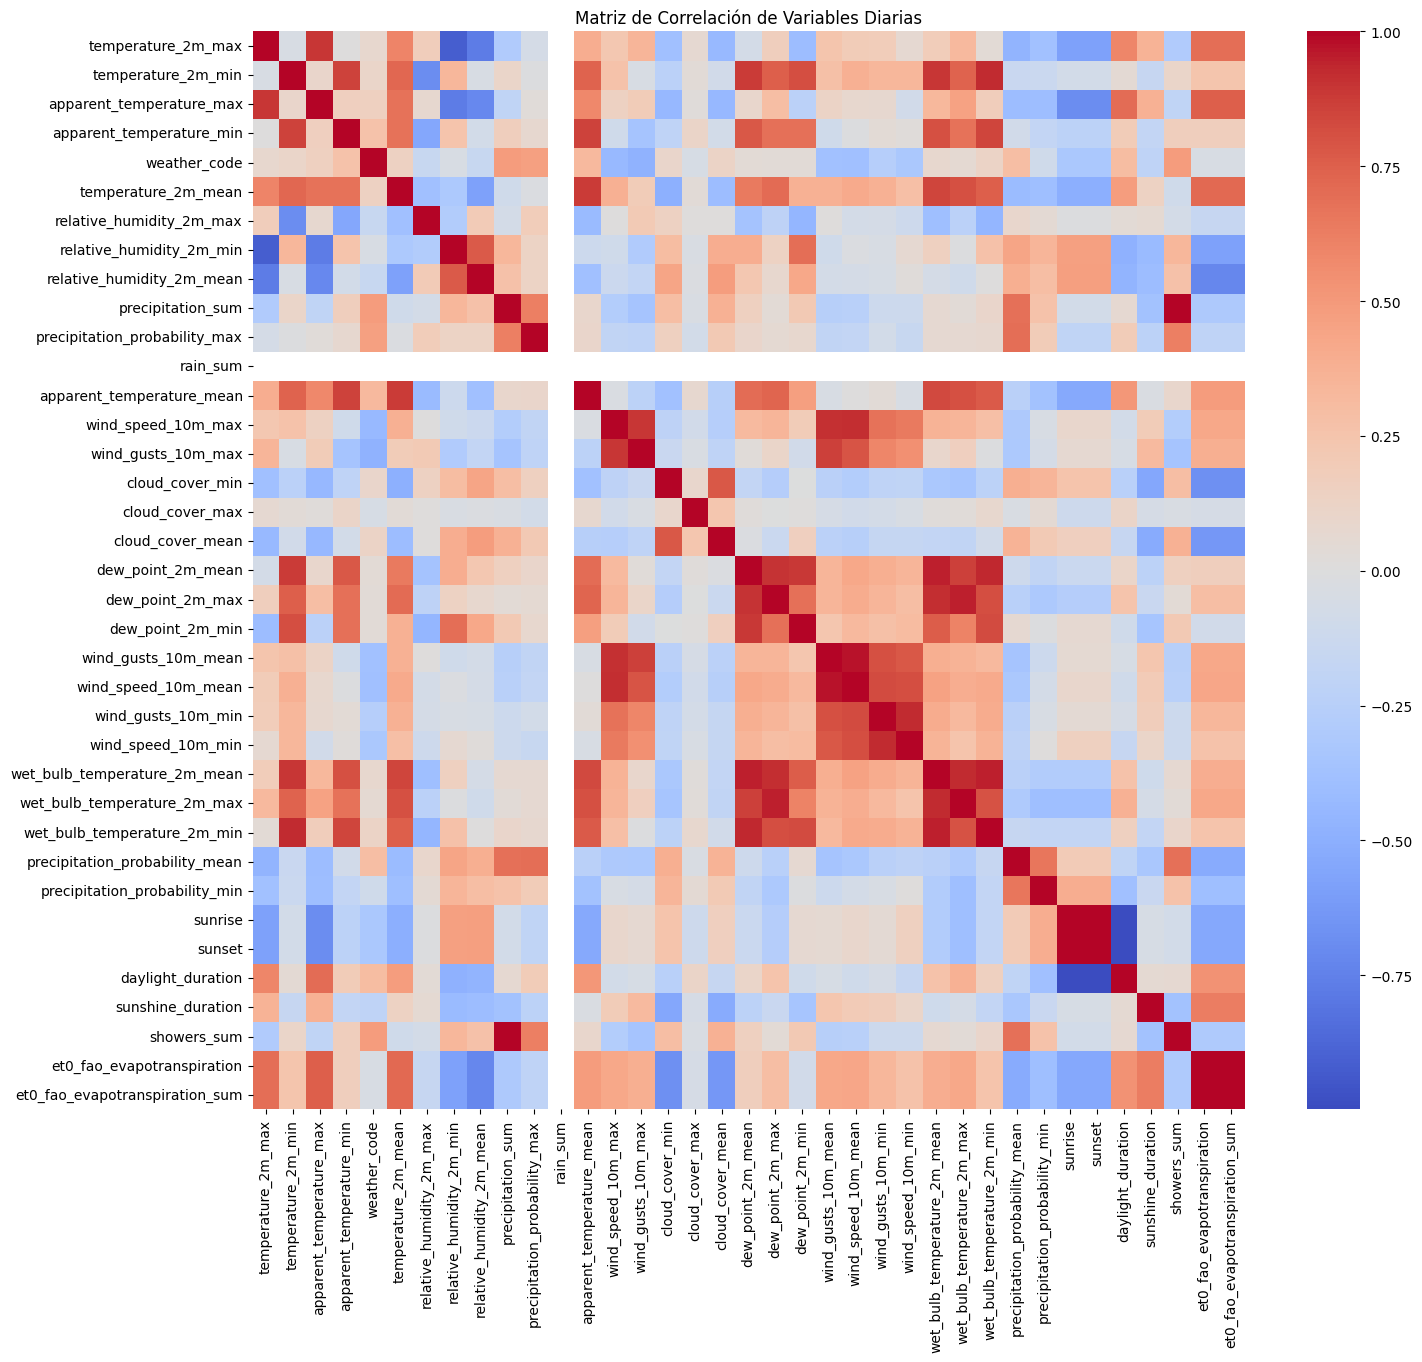

In [9]:
# Calcular la matriz de correlación solo para variables numéricas
corr_matrix = dfd.corr()

# Mostrar la correlación de la variable de estudio con todas las demás
print(f"\n--- Correlación de {variable_estudio} con otras variables ---")
print(corr_matrix[variable_estudio].sort_values(ascending=False).head(10))

# Visualizar la matriz de correlación (heatmap)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Diarias')
plt.show()

In [10]:
# 1. Preparar DataFrame para Prophet
df_prophet = dfd[[variable_estudio]].reset_index()
df_prophet.rename(columns={'time': 'ds', variable_estudio: 'y'}, inplace=True)
df_prophet['ds'] = df_prophet['ds'].dt.date # Prophet es más feliz con solo DATE para datos diarios

print("\nDataFrame listo para Prophet:")
print(df_prophet.head())


DataFrame listo para Prophet:
           ds     y
0  2025-08-23  42.0
1  2025-08-24  25.0
2  2025-08-25  22.0
3  2025-08-26   5.0
4  2025-08-27  23.0


In [15]:
from prophet import Prophet 

# 1. Inicializar y entrenar el modelo
model = Prophet(
    # Quita las lineas que importaste antes y stan_backend
    yearly_seasonality=False, 
    weekly_seasonality=True,  
    daily_seasonality=False
)
model.fit(df_prophet)

# 2. Predecir
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

# 3. Unir los resultados con el DataFrame original
df_anomalia = df_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']])

14:27:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# 1. Identificar Anomalías
# Un día es anómalo si el valor real está por encima o por debajo del intervalo
df_anomalia['anomaly'] = 0
df_anomalia.loc[df_anomalia['y'] > df_anomalia['yhat_upper'], 'anomaly'] = 1  # Anomalía alta
df_anomalia.loc[df_anomalia['y'] < df_anomalia['yhat_lower'], 'anomaly'] = -1 # Anomalía baja

# 2. Filtrar y mostrar los días anómalos
dias_anomalos = df_anomalia[df_anomalia['anomaly'] != 0].copy()

print("\n--- Días Anómalos Detectados ---")
print(dias_anomalos[['y', 'yhat', 'anomaly']].sort_index())
print(f"\nTotal de días anómalos encontrados: {len(dias_anomalos)}")


--- Días Anómalos Detectados ---
               y       yhat  anomaly
ds                                  
2025-08-26   5.0  26.998611       -1
2025-08-29  10.0  28.965421       -1
2025-09-01  68.0  36.801364        1
2025-09-07  71.0  23.069280        1
2025-09-15  12.0  38.435485       -1
2025-09-17  54.0  27.809856        1
2025-09-18  67.0  30.805567        1
2025-09-20   8.0  31.620877       -1
2025-09-23   6.0  30.266853       -1
2025-10-10  56.0  33.867784        1
2025-10-20  64.0  42.520787        1
2025-10-21  61.0  33.535096        1
2025-10-28  12.0  34.352156       -1
2025-10-31  15.0  36.318966       -1
2025-11-03  63.0  44.154909        1
2025-11-04  57.0  35.169217        1
2025-11-09  10.0  30.422825       -1
2025-11-11  70.0  35.986277        1
2025-11-15  75.0  38.157362        1
2025-11-16  66.0  31.239886        1

Total de días anómalos encontrados: 20


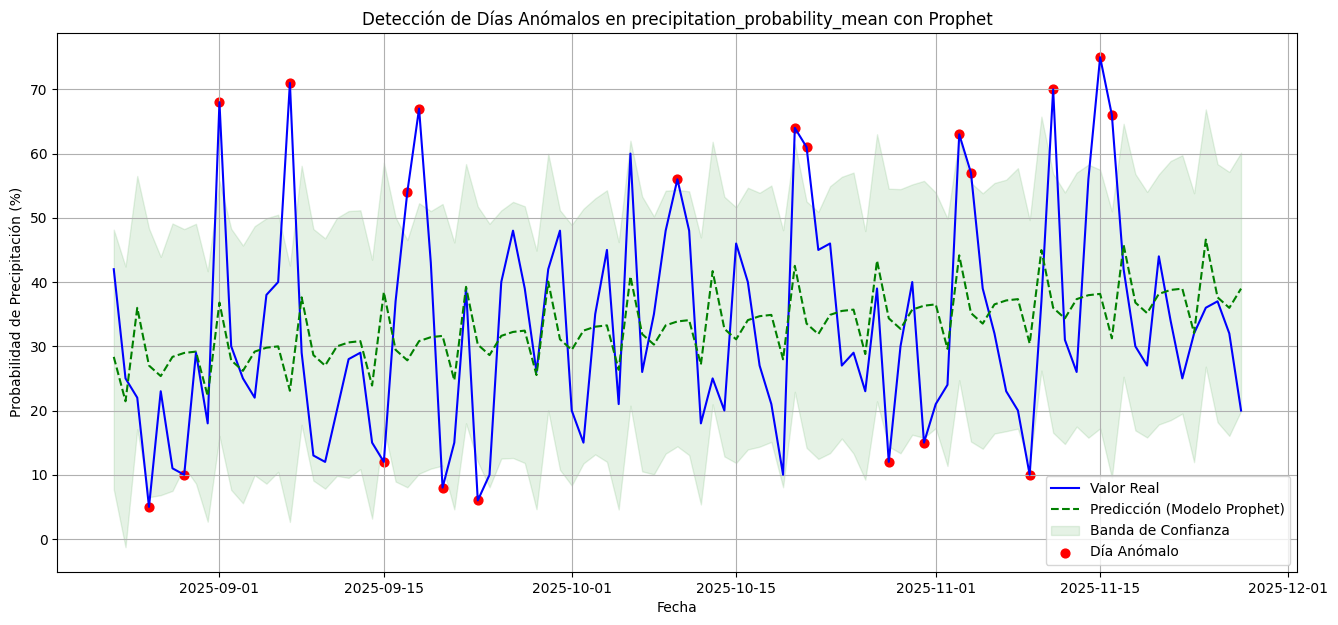

In [17]:
# 1. Gráfico de la serie de tiempo y la predicción
plt.figure(figsize=(16, 7))
plt.plot(df_anomalia.index, df_anomalia['y'], label='Valor Real', color='blue')
plt.plot(df_anomalia.index, df_anomalia['yhat'], label='Predicción (Modelo Prophet)', color='green', linestyle='--')

# 2. Sombrear la banda de confianza
plt.fill_between(df_anomalia.index, df_anomalia['yhat_lower'], df_anomalia['yhat_upper'], 
                 color='green', alpha=0.1, label='Banda de Confianza')

# 3. Marcar los puntos anómalos
plt.scatter(dias_anomalos.index, dias_anomalos['y'], color='red', s=40, label='Día Anómalo')

plt.title(f'Detección de Días Anómalos en {variable_estudio} con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad de Precipitación (%)')
plt.legend()
plt.grid(True)
plt.show()

# Prophet también tiene una función de visualización incorporada
# model.plot(forecast)
# model.plot_components(forecast)

In [18]:
# Aseguramos que 'df_anomalia' (resultado de Prophet) y 'dfd' (datos originales)
# estén unidas y listas.
# Usamos el índice de 'df_anomalia' para mapear las etiquetas de anomalía a dfd.

# Creamos una columna 'is_anomaly' en el DataFrame original.
dfd['is_anomaly'] = df_anomalia['anomaly']
df_comparison = dfd.dropna(subset=['is_anomaly'])

# Separamos los días en dos grupos: Normales (0) y Anómalos (1 o -1)
df_normal = df_comparison[df_comparison['is_anomaly'] == 0]
df_anomalous = df_comparison[df_comparison['is_anomaly'] != 0]

print(f"Total de días para análisis: {len(df_comparison)}")
print(f"Días Anómalos: {len(df_anomalous)}")

Total de días para análisis: 97
Días Anómalos: 20


In [21]:
# 2.1. Cálculo de Diferencias (CORREGIDO)

# Excluimos:
# 1. Columnas de etiquetado ('is_anomaly', 'precipitation_probability_mean')
# 2. Columnas de tiempo que causan el error: 'sunrise', 'sunset', 'daylight_duration', 'sunshine_duration'
#    (Aunque 'daylight_duration' y 'sunshine_duration' podrían ser útiles, son duraciones y requieren
#     un tratamiento diferente, como convertir a segundos/minutos antes de la comparación.
#     Por ahora, las excluiremos para evitar el TypeError).

cols_to_exclude = ['is_anomaly', 'precipitation_probability_mean', 
                   'sunrise', 'sunset', 'daylight_duration', 'sunshine_duration']

# Filtramos para obtener solo las columnas que son numéricas y escalares
metric_cols = [col for col in dfd.columns if col not in cols_to_exclude and 
               (dfd[col].dtype == 'float64' or dfd[col].dtype == 'int64')]

results = []

for col in metric_cols:
    
    # 1. Calcular estadísticas para días NORMALES
    normal_mean = df_normal[col].mean()
    normal_iqr = df_normal[col].quantile(0.75) - df_normal[col].quantile(0.25)
    
    # 2. Calcular estadísticas para días ANÓMALOS
    anom_mean = df_anomalous[col].mean()
    anom_iqr = df_anomalous[col].quantile(0.75) - df_anomalous[col].quantile(0.25)
    
    # 3. Calcular el cambio (magnitud de la diferencia)
    
    # Evitar división por cero o NaN
    if normal_mean == 0:
        mean_diff_percent = 9999.0 if anom_mean != 0 else 0.0 # Gran cambio si el normal era 0
    else:
        mean_diff_percent = ((anom_mean - normal_mean) / normal_mean) * 100
        
    iqr_ratio = anom_iqr / normal_iqr if normal_iqr != 0 else np.nan
        
    results.append({
        'Variable': col,
        'Media_Normal': normal_mean,
        'Media_Anomala': anom_mean,
        'Cambio_Media_Pct': mean_diff_percent,
        'Ratio_IQR_Anomalo_Normal': iqr_ratio
    })

df_analysis = pd.DataFrame(results)

# Ordenar y continuar con el análisis como antes
df_analysis['Abs_Change'] = df_analysis['Cambio_Media_Pct'].abs()
df_analysis = df_analysis.sort_values(by='Abs_Change', ascending=False).reset_index(drop=True)

# -----------------
# Mostrar Resultados
# -----------------
# print("\n--- 🔑 Variables Más Significativas para la Anomalía ---")
# print("  (Variables de Tiempo Excluidas)")
# print("---------------------------------------------------------")
# print(df_analysis[['Variable', 'Media_Normal', 'Media_Anomala', 'Cambio_Media_Pct', 'Ratio_IQR_Anomalo_Normal']].head(10).to_markdown(index=False, floatfmt=".2f"))

In [23]:
print("\n--- 🔑 Variables Más Significativas para la Anomalía ---")
print("  (Ordenadas por el mayor cambio porcentual en la Media)")
print("---------------------------------------------------------")
print(df_analysis[['Variable', 'Media_Normal', 'Media_Anomala', 'Cambio_Media_Pct', 'Ratio_IQR_Anomalo_Normal']].head(10).to_markdown(index=False, floatfmt=".2f"))


--- 🔑 Variables Más Significativas para la Anomalía ---
  (Ordenadas por el mayor cambio porcentual en la Media)
---------------------------------------------------------
| Variable                      |   Media_Normal |   Media_Anomala |   Cambio_Media_Pct |   Ratio_IQR_Anomalo_Normal |
|:------------------------------|---------------:|----------------:|-------------------:|---------------------------:|
| precipitation_probability_min |           4.96 |           12.90 |             160.03 |                       2.41 |
| showers_sum                   |           5.18 |            7.29 |              40.79 |                       1.88 |
| precipitation_sum             |           5.18 |            7.29 |              40.75 |                       1.88 |
| wind_gusts_10m_min            |           7.28 |            6.49 |             -10.87 |                       0.85 |
| weather_code                  |          77.31 |           85.25 |              10.27 |                       1.

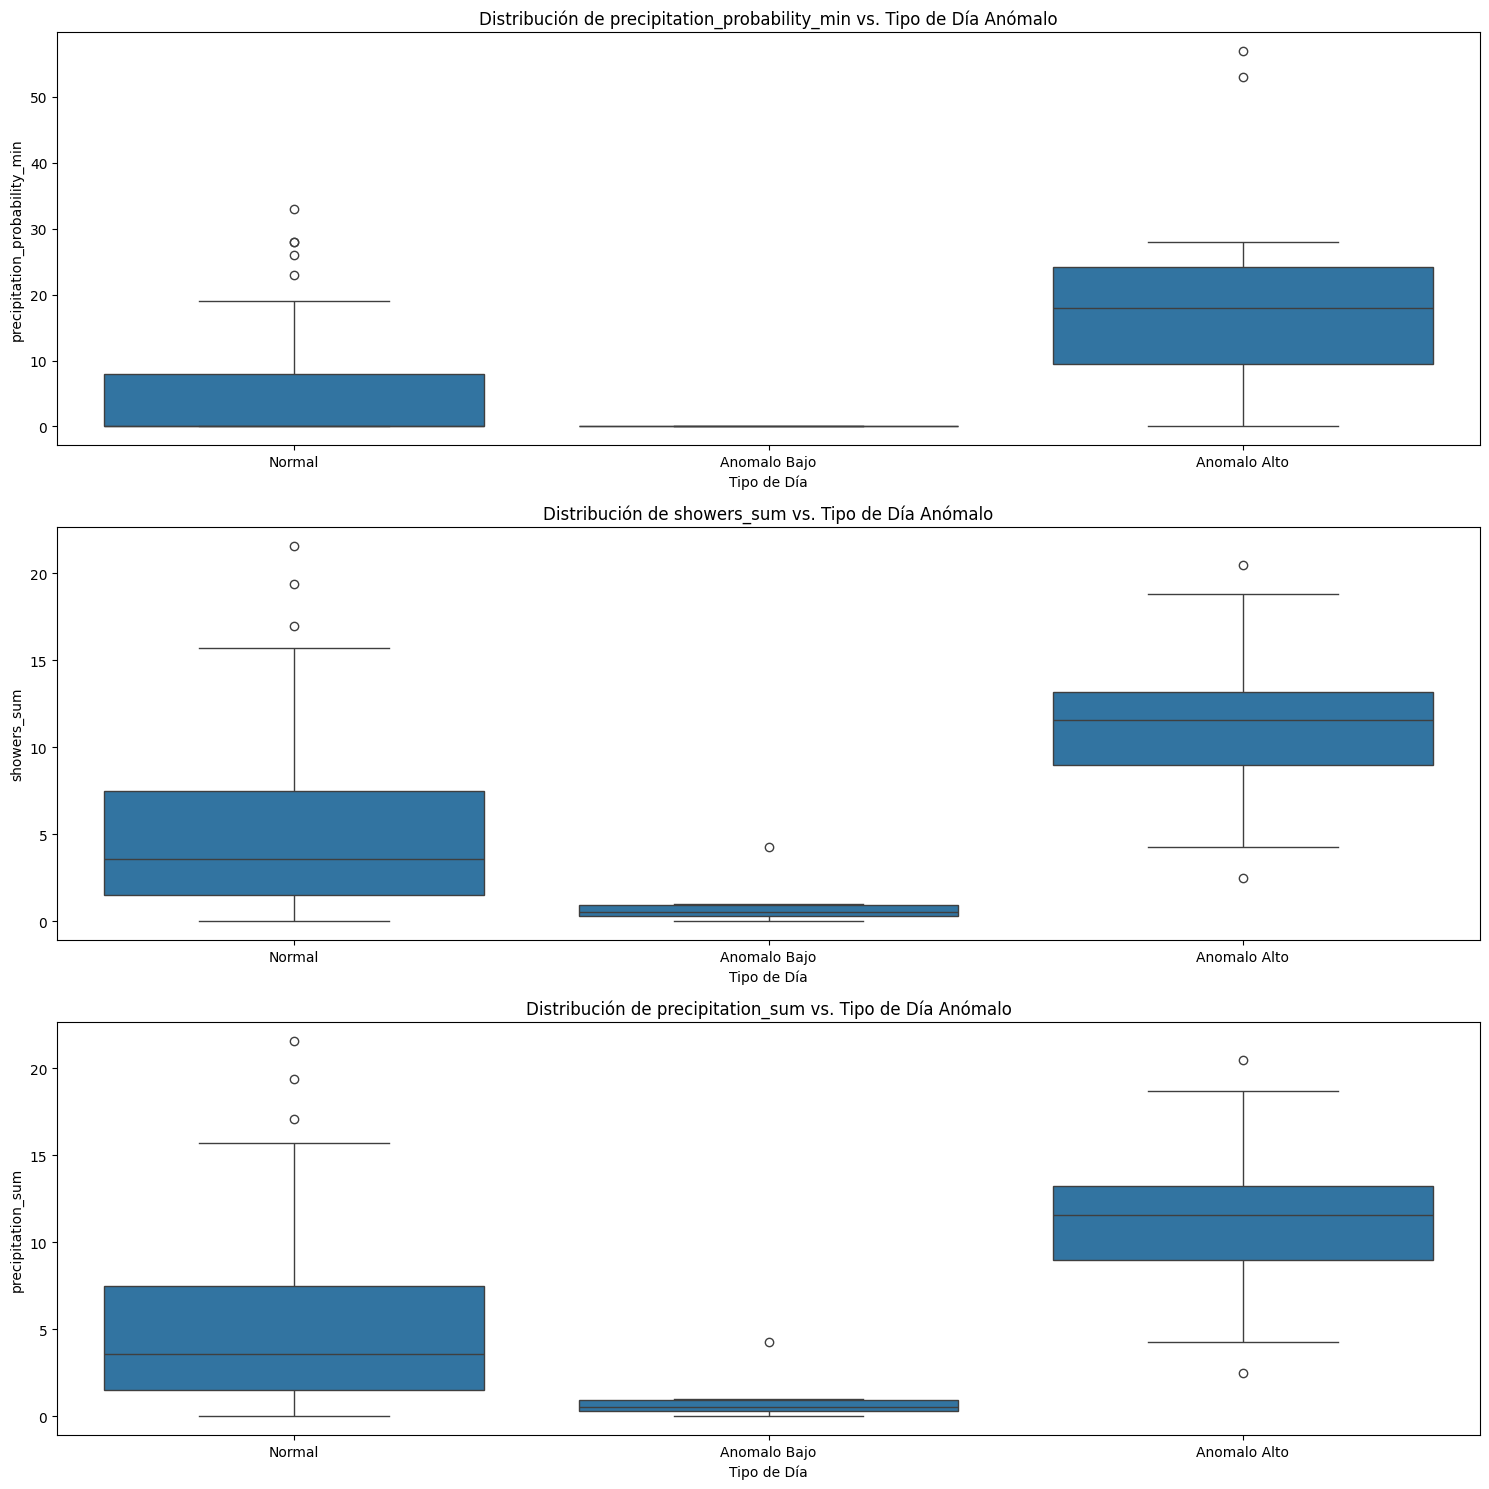

In [24]:
# Seleccionamos las 3 variables con mayor cambio para visualizar
top_3_vars = df_analysis.head(3)['Variable'].tolist()

if top_3_vars:
    plt.figure(figsize=(15, 5 * len(top_3_vars)))
    
    for i, var in enumerate(top_3_vars):
        plt.subplot(len(top_3_vars), 1, i + 1)
        sns.boxplot(x=df_comparison['is_anomaly'].replace({0: 'Normal', 1: 'Anomalo Alto', -1: 'Anomalo Bajo'}),
                    y=df_comparison[var])
        plt.title(f'Distribución de {var} vs. Tipo de Día Anómalo')
        plt.xlabel('Tipo de Día')
        plt.ylabel(var)
    
    plt.tight_layout()
    plt.show()